In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix

import torch.backends.cudnn as cudnn

### check GPU device

In [2]:
!nvidia-smi

Sat Feb 24 21:12:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

 mount with Goolge Drive if need to

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


check if cuda is avaiable

In [4]:
# check cuda

seed = 42
CUDA = True and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.0+cu121
CUDA version: 12.1



to load the MNIST dataset, use the appropriate path

In [5]:
# locate the MNIST data
def load_fashion_dataloaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize(X_DIM),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_set = torchvision.datasets.FashionMNIST(
        root='/content/drive/MyDrive/Data',
        train=True,
        download=True,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=8,
        shuffle=True,
        num_workers=2
    )

    test_set = torchvision.datasets.FashionMNIST(
        root='/content/drive/MyDrive/Data',
        train=False,
        download=True,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=1,
        shuffle=False
    )

    return train_loader, test_loader

In [6]:
train_loader, test_loader = load_fashion_dataloaders()
print(len(train_loader))
print(len(test_loader))

7500
10000


In [7]:
# 10 types of clothes in FashionMNIST dataset
def output_label(label):
  output_mapping = {
      0: "T-shirt/TOP",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle Boot"
  }

  input = (label.item() if type(label) == torch.Tensor else label)

  return output_mapping[input]

torch.Size([1, 28, 28])
tensor([6, 7, 3, 0, 2, 9, 0, 3])


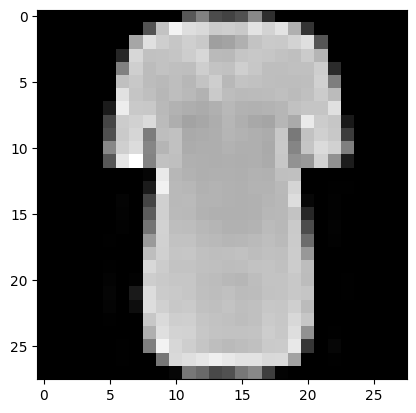

In [ ]:
img_show, label_show = next(iter(train_loader))
print(img_show[0].size())
plt.imshow(img_show[0].squeeze(), cmap="gray")
print(label_show)

In [8]:
class CNN(nn.Module):

	def __init__(self):
		super(CNN, self).__init__()
		self.main = nn.Sequential(

			# input is Z, going into a convolution
			nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
			nn.BatchNorm2d(8),
			nn.ReLU(True),
			nn.Dropout2d(p=0.1),

			nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2),
			nn.BatchNorm2d(16),
			nn.ReLU(True),
			nn.Dropout2d(p=0.1),

			nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
			nn.BatchNorm2d(32),
			nn.ReLU(True),
			nn.Dropout2d(p=0.1),

			nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
			nn.BatchNorm2d(64),
			nn.ReLU(True),
			nn.Dropout2d(p=0.2),

			nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
			nn.BatchNorm2d(128),
			nn.ReLU(True)
		)

		self.classifier = nn.Sequential(
			nn.Linear(128, 10),
		)

	def forward(self, x):
		x = self.main(x) #
		x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)  # GAP Layer
		logits = self.classifier(x)
		pred = F.softmax(logits, dim=1)

		return pred, logits, x


# cnn Model Training on MNIST Fashion Dataset
The model was trained for 10 epochs at lr=0.1, 20 epochs more at lr=0.01, 10 epochs more at lr=0.001 and 10 epochs more at lr=0.0002.



In [9]:
model = CNN().to(device)
model_checkpoint = torch.load('/content/drive/MyDrive/Data/cnn_lr_2e_4_epoch50.pth')
model.load_state_dict(model_checkpoint)

model

CNN(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout2d(p=0.2, inplace=False)
    (16): Conv2d(64, 128, kernel_size=(

In [ ]:
learning_rate = 0.00004
nn_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
num_epochs = 10
iters = 0

loss_list = []

sum_loss = 0.0
correct_predictions = 0
sum_samples = 0

for epoch in range(num_epochs):
  loss_list_epoch = []
  sum_loss = 0.0
  sum_samples = 0
  correct_predictions = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    prediction, _, _ = model(images)
    loss = nn_loss(prediction, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    predicted = torch.argmax(prediction, 1)
    correct_predictions += (predicted == labels).sum().item()
    sum_samples += labels.size(0)

    if i % 50 == 0:
      loss_list_epoch.append(loss.item())


    if (i % 500 == 0):
       print('[%d/%d][%d/%d]\tLoss: %.4f'% (epoch, num_epochs, i, len(train_loader), loss.item()))

  average_loss = sum_loss / len(train_loader)
  accuracy = correct_predictions / sum_samples
  loss_list.append(loss_list_epoch)

  print('Epoch: %d\t Average_loss: %.4f\t Accuracy: %.4f'% (epoch, average_loss, accuracy))


[0/10][0/7500]	Loss: 1.5862
[0/10][500/7500]	Loss: 1.4612
[0/10][1000/7500]	Loss: 1.4612
[0/10][1500/7500]	Loss: 1.4612
[0/10][2000/7500]	Loss: 1.4614
[0/10][2500/7500]	Loss: 1.4612
[0/10][3000/7500]	Loss: 1.5862
[0/10][3500/7500]	Loss: 1.4612
[0/10][4000/7500]	Loss: 1.4612
[0/10][4500/7500]	Loss: 1.5858
[0/10][5000/7500]	Loss: 1.5862
[0/10][5500/7500]	Loss: 1.5862
[0/10][6000/7500]	Loss: 1.6643
[0/10][6500/7500]	Loss: 1.4612
[0/10][7000/7500]	Loss: 1.4612
Epoch: 0	 Average_loss: 1.5523	 Accuracy: 0.9085
[1/10][0/7500]	Loss: 1.5862
[1/10][500/7500]	Loss: 1.4612
[1/10][1000/7500]	Loss: 1.5861
[1/10][1500/7500]	Loss: 1.6985
[1/10][2000/7500]	Loss: 1.4612
[1/10][2500/7500]	Loss: 1.5862
[1/10][3000/7500]	Loss: 1.4612
[1/10][3500/7500]	Loss: 1.6950
[1/10][4000/7500]	Loss: 1.5862
[1/10][4500/7500]	Loss: 1.4612
[1/10][5000/7500]	Loss: 1.4889
[1/10][5500/7500]	Loss: 1.5862
[1/10][6000/7500]	Loss: 1.8308
[1/10][6500/7500]	Loss: 1.7112
[1/10][7000/7500]	Loss: 1.5090
Epoch: 1	 Average_loss: 1.552

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Data/cnn_lr_4e_3_epoch50.pth')